# Isogeometric analysis of the Poisson equation: Non homogeneous boundary condition.

  Let $\Omega\subset\mathbb{R}^d$ be an open set with sufficiently smooth boundary, denoted by $\Gamma$, where $d=2$ is the number of spatial dimensions. Then, the problem stated in strong form as :

Find $\mathbf{c} :\overline{\Omega}\times(0,T)\longmapsto\mathbb{R}$ such that 
## $	\begin{align*}
		\left\lbrace\begin{array}{lll}
			 -\nabla \mathbf{A}(x)\cdot \nabla\mathbf{u} + \mathbf{B}\cdot\nabla\mathbf{u} + c\nabla\mathbf{u}&=~ f&\text{ in } \Omega ,~~~~~~~~~~(1)\\
		    \mathbf{u} &=~ g &\text{ on } \partial\Omega,~~~~~~~~(2)\\
		\end{array}\right.
	\end{align*}$
 Where $g\in H^{-\frac{1}{2}}(\partial\Omega)$ and $\mathbf{A}, \mathbf{B}\in \left(L^{\infty}(\Omega)\right)^2$.

## 2. Variational form and discrete formulation

Let X be the functional space and $\big(.,.\big)_\Omega$ denote the $L^2$ inner product with respect to  $\Omega$. We introduce the decomposition $\mathbf{u}= \mathbf{u}_0+\mathbf{u}_g $, where $\mathbf{u}_g\in X_g$. The variational formulation is stated as follows :

Find $\mathbf{u}_0\in X_0$, such that $\forall~w\in X_0$ : 

$$\textbf{B}\big(w,\mathbf{u}_0\big) = \mathbf{L}_g(w) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(8)$$

with

$$\begin{align*}\textbf{B}\big(w,\mathbf{v}\big) &= \big(\nabla
w,\mathbf{A}\nabla\mathbf{v}\big)_\Omega + \big(
w,\mathbf{B}\cdot\nabla\mathbf{v}\big)_\Omega+ \big(
w,c\mathbf{v}\big)_\Omega.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(9)\\
\textbf{L}_g\big(w\big) &= \big(w,f\big)_\Omega -\big(\nabla
w,\nabla\mathbf{u_g}\big)_\Omega - \big(
w,\mathbf{B}\cdot\nabla\mathbf{u_g}\big)_\Omega- \big(
w,c\mathbf{u_g}\big)_\Omega.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)
\end{align*}$$

The space discretization of (11) leads to the following variational problem over the finite element spaces : 

Find $\mathbf{u}^h \in X^h\subset X$, such that $\forall~w^h \in X^h$ : 

$$\textbf{B}\big(w^h, \mathbf{u}^h\big) = \textbf{L}_g\big(w^h\big) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)$$

where 

$$\mathbf{u}^h = \sum_{i=1}^{n_b} \mathbf{u}_iN_i, ~~~ w^h = \sum_{i=1}^{n_b} w_iN_i~~~~~~~~~~~~~~~~~~~~~~~~~~~~(11)$$

$n_b$ is the dimension of discrete space.

# 5. Numerical implementation under psydac.

# Mustapha

In [ ]:
# 2d linear Advection diffusion equation
#
# $$
# B .\nabla( u) - \nabla. A \nabla( u) = f
# $$

from sympy import pi, cos, sin, exp, log, symbols
from sympy.utilities.lambdify import implemented_function
import pytest

from sympde.calculus import grad, dot
from sympde.calculus import laplace
from sympde.topology import ScalarFunctionSpace
from sympde.topology import element_of
from sympde.topology import NormalVector
from sympde.topology import Square
from sympde.topology import Union
from sympde.expr     import BilinearForm, LinearForm, integral
from sympde.expr     import Norm
from sympde.expr     import find, EssentialBC
from sympde.expr.expr import linearize
from sympde.core     import Constant
from psydac.api.essential_bc   import apply_essential_bc

from psydac.fem.basic          import FemField
from psydac.api.discretization import discretize
# needed imports
from numpy import zeros, ones, linspace, zeros_like
from matplotlib.pyplot import plot, contourf, show, colorbar
from matplotlib import pyplot as plt

from sympde.topology.derivatives import dx1, dx2
from sympy import Tuple

# ... abstract model
domain  = Square()
B_dir   = domain.boundary

V       = ScalarFunctionSpace('V', domain)

x,y     = domain.coordinates

u,v     = [element_of(V, name=i) for i in ['u', 'v']]

#... Dirichlet (ud is free parameter and must be provided later)
ud      = element_of(V, name='ud')

#A       = (0.0115 * sin(2.*pi/3)**2+0.*x+0.*y ,0.0115 * sin(2.*pi/3)*cos(2.*pi/3)+0.*x+0.*y,
#            0.0115 * sin(2.*pi/3)*cos(2.*pi/3)+0.*x+0.*y,
#            0.0115 * cos(2.*pi/3)**2+0.*x+0.*y)
A       = ( (2. + cos(x))*(1. + y), cos(x + y) * sin(x + y),
            cos(x +y) * sin(x + y), (2. + sin(y))*(1. + x))

#B       = (y-0.5, 0.5- x)
B       = (11.+ sin(x) + y*sin(x) - 2.*cos(x + y)**2, -9. - cos(y) + x*cos(y) - 2.*cos(x + y)**2)

c       = 1.

#bracket = lambda a,b: dx1(a)*dx2(b) - dx2(a)*dx1(b)
bracket = lambda a,b: (A[0] * dx1(a) + A[1] * dx2(a) ) * dx1(b) + (A[2] * dx1(a) + A[3] * dx2(a) ) * dx2(b) + (B[0]*dx1(a) + B[1]*dx2(a))*b + c*a*b

#bracket = lambda a,b: (1.5 * dx1(a)) * dx1(b) + (1.5 * dx2(a) ) * dx2(b) + (B[0]*dx1(a) + B[1]*dx2(a))*b
#.. for non symetric solution (Pc)
solution = sin(3.*pi*y)*(x+0.5)**2
#solution = cos(2.*pi*x)*sin(2.*pi*y)
#f        = 3*pi*(0.5 - x1)*(x1 + 0.5)**2*cos(3*pi*x2) + 0.1035*pi**2*(x1 + 0.5)**2*sin(0.666666666666667*pi)**2*sin(3*pi*x2) + (2*x1 + 1.0)*(x2 - 0.5)*sin(3*pi*x2) - 0.023*sin(0.666666666666667*pi)**2*sin(3*pi*x2)
#.. for computation
f        = -dx1(A[0]*dx1(solution) + A[1]*dx2(solution)) - dx2(A[2]*dx1(solution) + A[3]*dx2(solution)) + B[0]*dx1(solution) + B[1]*dx2(solution) + c*solution
#f        = -dx1(1.5*dx1(solution)) - dx2(1.5*dx2(solution)) + B[0]*dx1(solution) + B[1]*dx2(solution)
# bilinear form
expr = bracket(u,v)
a    = BilinearForm((u,v), integral(domain , expr))

# bilinear form for the mass matrix
expr = u*v
m    = BilinearForm((u,v), integral(domain , expr))

# linear form for initial condition
expr = f*v - bracket(ud,v)
l    = LinearForm(v, integral(domain, expr) )
l_d  = LinearForm(v, integral(domain, solution*v) )

bc = [EssentialBC(u,    0., domain.boundary)]
equation = find(u, forall=v, lhs=a(u, v), rhs=l(v), bc= bc)
# ## Discretization using Psydac
from psydac.api.discretization import discretize
from psydac.api.settings       import PSYDAC_BACKEND_GPYCCEL
# ..
from scipy.sparse.linalg import gmres
from simplines import plot_field_2d

degree = [2,2]     # spline degree
ncells = [32,32]   # number of elements

class Adv_diffusion(object):
    
    def __init__(self, degree, ncells):

        # Create computational domain from topological domain
        domain_h = discretize(domain, ncells=ncells, comm=None)

        # Discrete spaces
        Vh   = discretize(V, domain_h, degree=degree)

        # Discretize the bilinear forms
        ah   = discretize(a, domain_h, [Vh, Vh])#, backend=PSYDAC_BACKEND_GPYCCEL)
        mh   = discretize(m, domain_h, [Vh, Vh])#, backend=PSYDAC_BACKEND_GPYCCEL)

        # Discretize equation using Dirichlet bc
        equation_h = discretize(equation, domain_h, [Vh, Vh])

        # Discretize the linear form for the initial condition
        lh   = discretize(l, domain_h, Vh)#, backend=PSYDAC_BACKEND_GPYCCEL)
        lh_d = discretize(l_d, domain_h, Vh)#, backend=PSYDAC_BACKEND_GPYCCEL)

        # Error norms
        error  = u - solution
        l2norm = Norm(error, domain, kind='l2')

        # assemble matrices and convert them to scipy
        M  = mh.assemble().tosparse()
        S  = ah.assemble()
        # ...

        nbasis = [W.nbasis for W in Vh.spaces]

        # L2 projection of the solution (we computes here Dirichlet boundary condition)
        # assemble the rhs and convert it to numpy array
        rhs_d          = lh_d.assemble().toarray()
        u_d, status    = gmres(M, rhs_d, tol=1.e-8, maxiter=5000)
        # ---
        u_d            = u_d.reshape(nbasis)
        u_d[1:-1,1:-1] = 0.
        udh            = FemField( Vh, Vh.vector_space.zeros() )
        udh.coeffs[0:nbasis[0],0:nbasis[1]]  = u_d[:,:]

        #plot_field_2d(Vh.knots, Vh.degree, un) ; colorbar() ; show()
        #plot_field_2d(Vh.knots, Vh.degree, un.reshape(nbasis), vmin=0., vmax=1.) ; colorbar() #; show()

        #
        rhs          = lh.assemble(ud = udh)
        apply_essential_bc(S, *equation_h.bc, identity=True)
        apply_essential_bc(rhs, *equation_h.bc)

        S            = S.tosparse()
        rhs          = rhs.toarray()
        # Discretize error norms
        l2norm_h     = discretize(l2norm, domain_h, Vh)
        # ------
        self.l2norm_h= l2norm_h
        self.Vh      = Vh 
        self.nbasis  = nbasis
        # ...
        self.S       = S
        self.rhs     = rhs
        self.M       = M
        self.u_d     = u_d
        self.udh     = udh
    def solve(self):
        Vh           = self.Vh
        S            = self.S
        rhs          = self.rhs
        nbasis       = self.nbasis
        u_d          = self.u_d
        # ...
        u_ap, status = gmres(S, rhs, tol=1.e-6, maxiter=3000)
        u_ap         = u_ap.reshape(nbasis)
        u_ap[:, :]  += u_d[:, :]

        plot_field_2d(Vh.knots, Vh.degree, u_ap.reshape(nbasis)) ; colorbar() #; show()
        #plot_field_2d(Vh.knots, Vh.degree, un.reshape(nbasis), vmin=0., vmax=1.) ; colorbar() #; show()
        #plt.savefig('u.png')
        return u_ap

    def l2_error(self, u_ap):
        Vh        = self.Vh 
        nbasis    = self.nbasis
        l2norm_h  = self.l2norm_h
        
        uh        = FemField( Vh, Vh.vector_space.zeros() )
        uh.coeffs[0:nbasis[0],0:nbasis[1]]  = u_ap[:,:]
        val_error = self.l2norm_h.assemble(u=uh)
        print('le-error = ', val_error)
        return val_error
    
ad = Adv_diffusion(degree, ncells)

le-error =  0.00011957855099263165


0.00011957855099263165

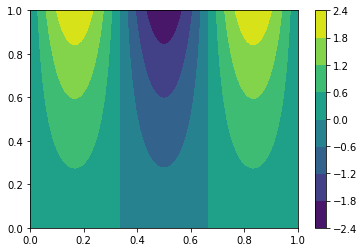

In [12]:
u_ap = ad.solve()
ad.l2_error(u_ap)

In [14]:
#for stifness matrix
#ad.S
#for mass matrix
#ad.M
#for rhs vector
ad.rhs[10:50]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.40921082e-04,  1.16949147e-03,  1.21492779e-03,
        1.20796040e-03,  1.13329624e-03,  9.78196829e-04,  7.35390652e-04,
        4.05450017e-04, -1.49529865e-06, -4.65061143e-04, -9.55099303e-04,
       -1.43345284e-03, -1.85689423e-03, -2.18102230e-03, -2.36476994e-03])

## Here's another way to write the code TODO

In [ ]:
from sympy import pi, cos, sin, exp, log, symbols
from sympy.utilities.lambdify import implemented_function
import pytest

from sympde.calculus import grad, dot
from sympde.calculus import laplace
from sympde.topology import ScalarFunctionSpace
from sympde.topology import element_of
from sympde.topology import NormalVector
from sympde.topology import Square
from sympde.topology import Union
from sympde.expr     import BilinearForm, LinearForm, integral
from sympde.expr     import Norm
from sympde.expr     import find, EssentialBC
from sympde.expr.expr import linearize
from sympde.core     import Constant

from psydac.fem.basic          import FemField
from psydac.api.discretization import discretize

x,y,z = symbols('x1, x2, x3')

from sympy import diff
dx      = lambda e: diff(e,x)
dy      = lambda e: diff(e,y)


# ..Topological domain
domain = Square()
B_dirichlet_0 = domain.boundary

# ..Function Space
V      = ScalarFunctionSpace('V', domain)
p      = 3 
nbe    = 5
#...
degree = [p,p]       #.. degree = 2, 3
ncells = [2**nbe,2**nbe] #.. ncells= 2**4,5,6


# .. Defining the Linear form $G$
u        = element_of(V, name='u')
v        = element_of(V, name='v')
#.. Tools of Poisson equation
A        = 1. #0.0115 * sin(2.*pi/3)**2+0.*x+0.*y #, 0.0115 * sin(2.*pi/3)*cos(2.*pi/3)+0.*x+0.*y, 0.0115 * cos(2.*pi/3)**2+0.*x+0.*y)
B        = (y-0.5, 0.5- x)

#.. for non symetric solution (Pc)
#solution = sin(3.*pi*y)*(x+0.5)**2
solution = sin(2.*pi*x)*sin(2.*pi*y)
#f        = 3*pi*(0.5 - x1)*(x1 + 0.5)**2*cos(3*pi*x2) + 0.1035*pi**2*(x1 + 0.5)**2*sin(0.666666666666667*pi)**2*sin(3*pi*x2) + (2*x1 + 1.0)*(x2 - 0.5)*sin(3*pi*x2) - 0.023*sin(0.666666666666667*pi)**2*sin(3*pi*x2)
#.. for computation
f        = A * (-dx(  dx(solution)) - dy( dy(solution) ) ) + B[0] * dx(solution) + B[1] * dy(solution)


# Linear form l: V --> R
l = LinearForm(v, integral(domain, f * v))

# Bilinear form a: V x V --> R
a = BilinearForm((u, v), integral(domain, A * dot( grad(u), grad(v)) + (B[0]*dx(u) +B[1]*dy(u)) * v ))

#a = BilinearForm((u, v), integral(domain, (A[0] * dx(u) + A[1] * dy(u) ) * dx(v) + (A[1] * dx(u) + A[2] * dy(u) ) * dy(v) + (B[0]*dx(u) + B[1]*dy(u))*v ) )


bc = [EssentialBC(u,    solution, domain.boundary)]
equation = find(u, forall=v, lhs=a(u, v), rhs=l(v), bc= bc)
# Create computational domain from topological domain
from mpi4py import MPI
domain_h = discretize(domain, ncells=ncells)#, comm=MPI.COMM_WORLD)

# Discrete spaces
Vh = discretize(V, domain_h, degree=degree)

# Discretize equation using Dirichlet bc
equation_h = discretize(equation, domain_h, [Vh, Vh])


# First guess: zero solution
#u_dh  = FemField(Vh)
nbasis = [ncells[0]+degree[0], ncells[1]+degree[1]]

# Solve linear system
u_h = equation_h.solve()

# Error norms
error  = u - solution
l2norm = Norm(error, domain, kind='l2')
# Discretize error norms
l2norm_h = discretize(l2norm, domain_h, Vh)
print('le-error = ', l2norm_h.assemble(u=u_h))

from matplotlib import pyplot as plt
from simplines import plot_field_2d
nbasis = [w.nbasis for w in Vh.spaces]
p1,p2 = Vh.degree
x = u_h.coeffs._data[p1:-p1,p2:-p2]
u = x.reshape(nbasis)
plot_field_2d(Vh.knots, Vh.degree, u) ; plt.colorbar()